In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp

import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
from scipy import optimize
import arrow
import gsw
import pandas as pd
%matplotlib inline

/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Part 1: Use  isopycnal vs ventilation age relationship to get age of watermass estimate, then use co2 levels at that age to get identity of co2 intrusion



    1) plot age of water as fxn of isopycnal - use scipy-optimize...
    2) plot intrusion of pco2 as fxn of age...what is the 'correct' reference here?
    
problem - the age of water as a function of isopycnal gets very exponential very quickly- an isopycnal of 25.7 has an age of ~320 years. 


##### atmospheric CO2 - used co2levels.org data sources, 
###### smoothed yearly product (ice core 1832-1959, maunaloa 1959-pres)

    1832- 1958: https://cdiac.ess-dive.lbl.gov/ftp/trends/co2/lawdome.combined.dat
    1959 - pres: https://www.co2levels.org/#sources


### PPM CO2 from 1832-2018, using above sources, and code to look up atmco2 for a given year from 1832-2018

In [4]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 


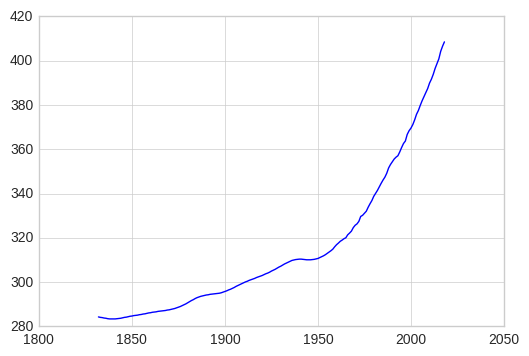

In [5]:
plt.plot(co2_rec['YEAR'],co2_rec['PPMCO2'])

In [6]:
co2_rec = pd.read_csv('lawdome_maunaloa.csv') 
def co2_from_year(year):
    '''takes a value for a year, converts year to int,
    and finds appropriate co2 values  from pandas lookup table. 
    if year < 1832, value is for year 1832, if year > 2018, value is for year 2018'''
    
    whole_year = int(year)
    
    if whole_year >= 2018:
        whole_year = 2018     
        #print('year > 2018, using value for 2018')
        
    if whole_year <= 1832:
        whole_year = 1832
        #print('year < 1832, using value for 1832')

    match = (co2_rec['YEAR'] == whole_year) 
    atmco2 = co2_rec['PPMCO2'][match]
    t_co2 = atmco2.values[0]
    return t_co2

In [7]:
ty = 1000
tco2 = co2_from_year(ty)
print(tco2)

284.3


## from Tetjana's plot, define pycnals and ventilation age, use scipy curve_fit to make a fxn of ventilation time/year last at surface vs pycnal, use above code to find atm co2 when pycnal was last at surface

In [9]:

pycnal = np.array([24.4, 25.15, 25.4, 25.6])
pycnal_age = np.array([0,1,10,100])

def test_func(x, a, b, c):
    return a * np.exp(-b * (25.15-x)) + c

params, params_covariance = optimize.curve_fit(test_func, pycnal, pycnal_age,
                                               p0=[1, -0.05, -25.15])
params0 = params[0]
params1 = params[1]
params2 = params[2]
print(params0)
print(params1)
print(params2)

pycnal_forfunc =np.arange(24.4,27,0.05)
pycnal_age_fromfunc = params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2
pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-pycnal_forfunc))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)

for i in range(0,len(pycnal_original_co2)):
    ty = pycnal_last_at_surface[i]
    tco2 = co2_from_year(ty)
    pycnal_original_co2[i] = tco2
    
    
pycnal_intrusion = 409 - pycnal_original_co2


0.5406570488955575
11.595484591464743
0.2153367515219747


## ventilation age as a fxn of isopycnal, station P04, km 220

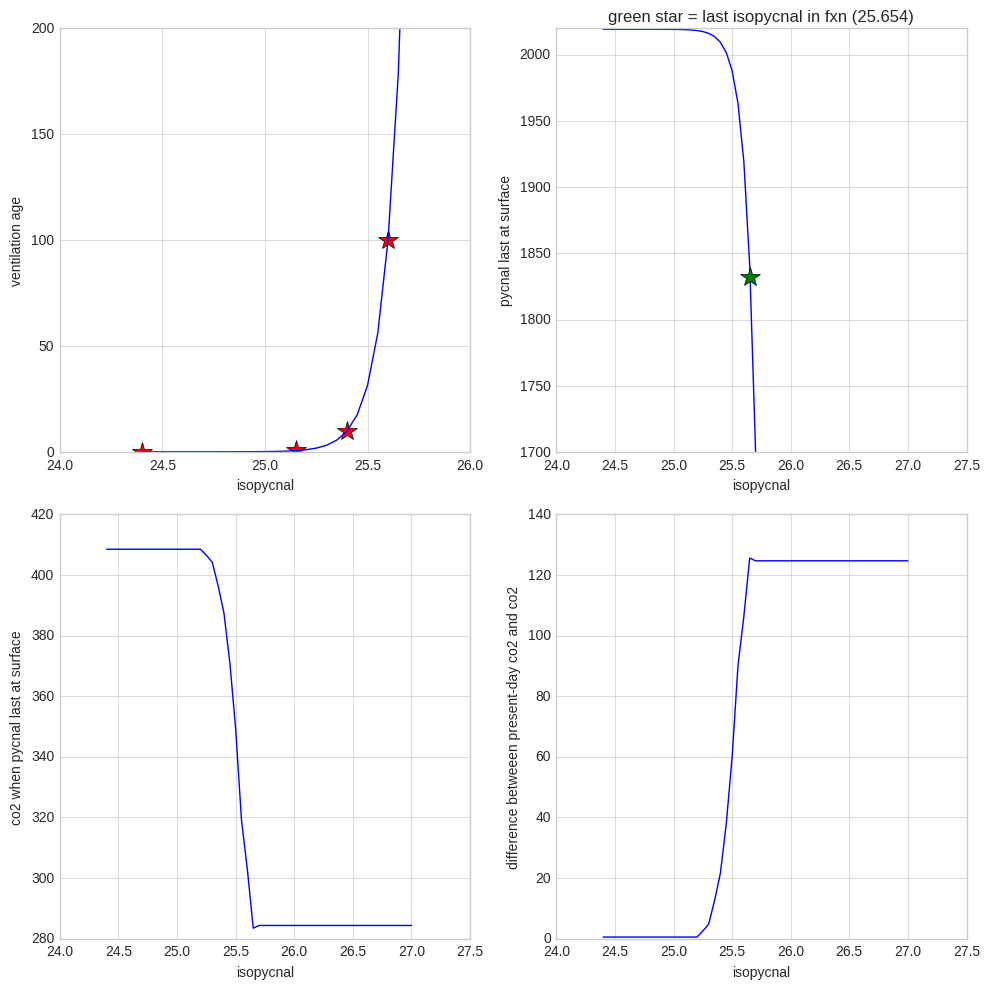

In [10]:
fig = plt.figure(figsize=(10,10))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(2,2,i)
        ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_age_fromfunc)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('ventilation age')
        ax.set_xlim([24.0,26.0])
        ax.set_ylim([0,200])
        

    if i == 2:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_last_at_surface)
        ax.plot(25.654,1832.1497986658724,'g*', markersize = 15)
        ax.set_ylim([1700,2020])
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('pycnal last at surface')
        ax.set_title('green star = last isopycnal in fxn (25.654)')

    if i == 3:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_original_co2)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('co2 when pycnal last at surface')


    if i == 4:
        ax = fig.add_subplot(2,2,i)
        #ax.plot(pycnal,pycnal_age,'r*', markersize = 15)
        ax.plot(pycnal_forfunc,pycnal_intrusion)
        ax.set_xlabel('isopycnal')
        ax.set_ylabel('difference betweeen present-day co2 and co2')

   
        
plt.tight_layout()

In [11]:
pycnal_forfunc2 = 25.654
pycnal_age_fromfunc = params[0] *np.exp(-params[1]*(25.15-pycnal_forfunc2))+params[2]

pycnal_last_at_surface = 2019 - pycnal_age_fromfunc
print('Max pycnal for function: ', pycnal_forfunc2)
print('last at surface:', pycnal_last_at_surface)

Max pycnal for function:  25.654
last at surface: 1832.1497986658724


In [12]:
# test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
# zlevels = (test_LO['deptht'][:])
# sal = test_LO['vosaline'][0,:,0,:]
# temp = test_LO['votemper'][0,:,0,:]
# potdens = gsw.sigma0(sal,temp)
# print('max pot dens:', np.max(potdens))
# print('min pot dens:', np.min(potdens))
# potdens_mask = np.copy(potdens)
# potdens_mask[potdens>24.4] = 1
# potdens_mask[potdens<=24.4] = -1
# potdens_age = np.copy(potdens)

# for i in range(0,40):
#     for j in range(0,950):
#         potdens_age[i,j] = params[0] *np.exp(-params[1]*(25.15-potdens[i,j]))+params[2] 
# potdens_age[potdens<=24.4] = 0
# potdens_age[potdens_age>129] = 129


# w = np.where( potdens > 25.7 )

# #print('size of BC array:' np.size(potdens))
# print('Proportion of BC array > 25.7:', np.size(w)/np.size(potdens))


In [13]:
# fig = plt.figure(figsize=(11,3.5))
# nop = 4
# for i in range(1,nop+1):

#     if i == 1:
#         ax = fig.add_subplot(1,4,i)
#         section_slice = np.arange(0, 95)
#         sd = (potdens)
#         tplt = np.ma.masked_values(sd,0)
#         tcmap = cm.cm.deep
#         cmap = tcmap
#         mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=20, vmax=30)
#         cbar = fig.colorbar(mesh, ax=ax)
#         ax.invert_yaxis()
#         land_colour = 'slategrey'
#         cmap.set_bad(land_colour)
#         plt.title('potential density of BC') 
#         ax.set_ylabel('depth')
#         ax.set_xticklabels([])
        
#     if i == 2:
#         ax = fig.add_subplot(1,4,i)
#         section_slice = np.arange(0, 95)
#         sd = (potdens_mask)
#         tplt = np.ma.masked_values(sd,0)
#         tcmap = cm.cm.balance
#         cmap = tcmap
#         mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-1, vmax=1)
#         cbar = fig.colorbar(mesh, ax=ax)
#         ax.invert_yaxis()
#         land_colour = 'slategrey'
#         cmap.set_bad(land_colour)
#         plt.title('potential density of BC (1 means >24.4)') 
#         ax.set_ylabel('depth')
#         ax.set_xticklabels([])

      
# plt.suptitle('y2018m01d01', fontsize = 15)
# plt.tight_layout()

## Visualize potential density of incoming BC waters - see where it is >24.4

#### June 1, 2018 - more 'exciting' - deeper waters coming up

In [14]:
test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc')
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
potdens = gsw.sigma0(sal,temp)
potdens_mask = np.copy(potdens)
potdens_mask[potdens>24.4] = 1
potdens_mask[potdens<=24.4] = -1

DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]

depth_this = np.zeros_like(TA)

for i in range(0,950):
    depth_this[:,i] = zlevels

In [15]:

pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-potdens))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)
np.shape(pycnal_original_co2)
for i in range(0,40):
    for j in range(0,950):
        ty = pycnal_last_at_surface[i,j]
        tco2 = co2_from_year(ty)
        pycnal_original_co2[i,j] = tco2


pycnal_intrusion = 409 - pycnal_original_co2

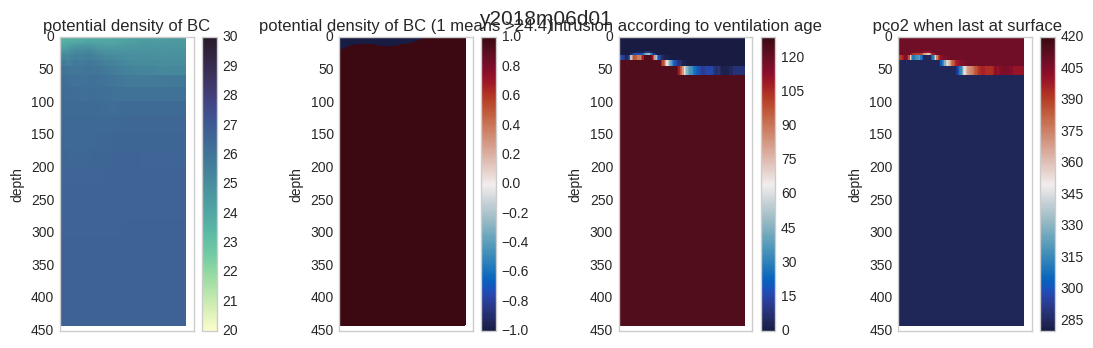

In [16]:
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (potdens)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=20, vmax=30)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (potdens_mask)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=-1, vmax=1)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC (1 means >24.4)') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 3:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_intrusion)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=0, vmax=129)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('intrusion according to ventilation age') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])   
        
    if i == 4:
        ax = fig.add_subplot(1,4,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_original_co2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.balance
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=280, vmax=420)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title(' pco2 when last at surface') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])    


        
plt.suptitle('y2018m06d01', fontsize = 15)
plt.tight_layout()

In [17]:
def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):

    size_box = np.shape(tdic)
    size_0 = size_box[0]
    size_1= size_box[1]


    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
        
    tsra_psu = tsra*35/35.16504
    ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

    pHr = pH.reshape(size_0,size_1)
    OmAr = OmegaA.reshape(size_0,size_1)
    pco2r = pco2.reshape(size_0,size_1)
    
    return pHr, OmAr, pco2r

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
    if ans> 2:
        print('Danger, pco2 found >2 uatm from pco2 given')
#     print(idx)
#     print('difference between real pco2 and pco2 from calc. dic: ',ans)
#     print('DIC found this way:', tdic_r[idx]*1e3)
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic
    
# test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m06d01.nc')
# zlevels = (test_LO['deptht'][:])
# sal = test_LO['vosaline'][0,:,0,:]
# temp = test_LO['votemper'][0,:,0,:]
# DIC = test_LO['DIC'][0,:,0,:]
# TA = test_LO['TA'][0,:,0,:]

# depth_this = np.zeros_like(TA)

# for i in range(0,950):
#     depth_this[:,i] = zlevels

# pHr, OmAr, pco2r = oned_moxy(sal, temp, DIC, TA, 1, depth_this)

# pco2r_preind = np.copy(pco2r)
# #preindustrial pco2 is 280
# pco2r_preind = pco2r - 129

# preind_dic = np.zeros_like(DIC)
# preind_dic_r = np.ravel(preind_dic)
# pco2r_preind_r = np.ravel(pco2r_preind)
# depth_r = np.ravel(depth_this)
# sal_r = np.ravel(sal)
# temp_r = np.ravel(temp)
# DIC_r = np.ravel(DIC)
# TA_r = np.ravel(TA)
# for i in range(0,len(depth_r)):
#     if i%950 == 0:
#         print(i)
#     t_dic = find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], pco2r_preind_r[i], TA_r[i], 1, depth_r[i])
#     preind_dic_r[i] = t_dic

# preind_dic_fin = preind_dic_r.reshape(40,950)




# f = nc.Dataset('LOy2018m06d01_preind_DIC.nc','w', format='NETCDF4') #'w' stands for write
# g = f.createGroup('model_output')
# #g.createDimension('days', len(NO3_mod))
# g.createDimension('xval', 950)
# g.createDimension('depth', 40)
# ts = g.createVariable('preind_dic','f4',('depth','xval'))
# ts[:] = preind_dic_fin

# f.close()

## Steps to creating a BC file with preindustrial DIC

#### 1) open a boundary condition file and visualize DIC and POT DENS

#### 2) find and visualize present-day PCO2 

#### 3) find and visualize intrusion from pot-dens

#### 4) find supposed preindustrial PCO2 by subtracting intrusion from present-day PCO2

#### 5) calculate DIC from said preindustrial PCO2, present-day TA

#### 5b) write a new boundary condition file

In [18]:
##1) 

test_LO = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2018m01d01.nc')
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
potdens = gsw.sigma0(sal,temp)
potdens_mask = np.copy(potdens)
potdens_mask[potdens>24.4] = 1
potdens_mask[potdens<=24.4] = -1

zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]

depth_this = np.zeros_like(TA)

for i in range(0,950):
    depth_this[:,i] = zlevels

pHr, OmAr, pco2r = oned_moxy(sal, temp, DIC, TA, 1, depth_this)

pco2_resh = pco2r.reshape(40,950)


## 1) open a boundary condition file and visualize DIC and POT DENS

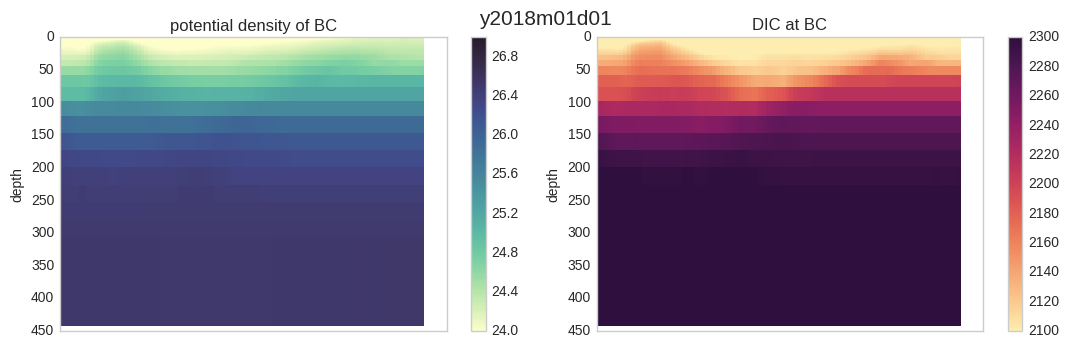

In [19]:
fig = plt.figure(figsize=(11,3.5))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (potdens)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=24, vmax=27)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('potential density of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (DIC)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.matter
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=2100, vmax=2300)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('DIC at BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])

plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

## 2) find and visualize present-day PCO2 

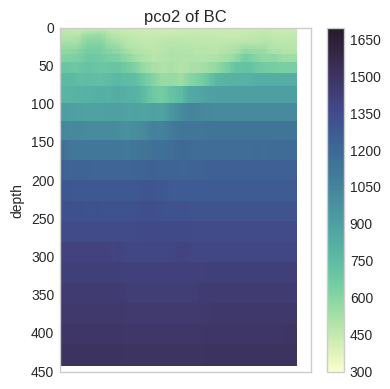

In [20]:
pco2_resh

fig = plt.figure(figsize=(4,4))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,1,i)
        section_slice = np.arange(0, 95)
        sd = (pco2_resh)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=300, vmax=1700)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        

#plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

In [21]:
pycnal_last_at_surface = 2019 - params0 *np.exp(-params1*(25.15-potdens))+params2

pycnal_original_co2 = np.zeros_like(pycnal_last_at_surface)
np.shape(pycnal_original_co2)
for i in range(0,40):
    for j in range(0,950):
        ty = pycnal_last_at_surface[i,j]
        tco2 = co2_from_year(ty)
        pycnal_original_co2[i,j] = tco2


pycnal_intrusion = 409 - pycnal_original_co2

KeyboardInterrupt: 

In [ ]:
pco2_resh

fig = plt.figure(figsize=(4,4))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,1,i)
        section_slice = np.arange(0, 95)
        sd = (pycnal_intrusion)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=0, vmax=140)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 intrusion of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        

#plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

In [ ]:
preind_pco2 = pco2_resh - pycnal_intrusion

In [ ]:
pco2_resh

fig = plt.figure(figsize=(8,4))
nop = 4
for i in range(1,nop+1):

    if i == 1:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (pco2_resh)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=400, vmax=1500)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 of BC') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
        
    if i == 2:
        ax = fig.add_subplot(1,2,i)
        section_slice = np.arange(0, 95)
        sd = (preind_pco2)
        tplt = np.ma.masked_values(sd,0)
        tcmap = cm.cm.deep
        cmap = tcmap
        mesh = ax.pcolormesh(section_slice[:],zlevels[:],tplt[:,0:95], cmap = tcmap, vmin=400, vmax=1500)
        cbar = fig.colorbar(mesh, ax=ax)
        ax.invert_yaxis()
        land_colour = 'slategrey'
        cmap.set_bad(land_colour)
        plt.title('pco2 of BC - preindustrial') 
        ax.set_ylabel('depth')
        ax.set_xticklabels([])
#plt.suptitle('y2018m01d01', fontsize = 15)
plt.tight_layout()

In [ ]:
preind_dic = np.zeros_like(DIC)
preind_dic_r = np.ravel(preind_dic)
pco2r_preind_r = np.ravel(preind_pco2)
depth_r = np.ravel(depth_this)
sal_r = np.ravel(sal)
temp_r = np.ravel(temp)
DIC_r = np.ravel(DIC)
TA_r = np.ravel(TA)
for i in range(0,len(depth_r)):
    if i%950 == 0:
        print(i)
    t_dic = find_DIC_corresp_to_pco2(sal_r[i], temp_r[i], pco2r_preind_r[i], TA_r[i], 1, depth_r[i])
    preind_dic_r[i] = t_dic

preind_dic_fin = preind_dic_r.reshape(40,950)

In [28]:
#this script takes the preindustrial boundary condition values 
#calculated in preind_DIC_BC_loop2 and puts them in the right format
#to mimc the LO boundary conditions.

def preind_dic_ncmaker(startind, endind, year):
#1 open given boundary conditions file and findpco2 and potential density 
    daymon = [31,28,31,30,31,30,31,31,30,31,30,31]
    daymon_LY = [31,29,31,30,31,30,31,31,30,31,30,31]

    year_ar = []
    noday = 365
    if year == 2016:
        t_daymon = daymon_LY
        noday = 366
    else:
        t_daymon = daymon

    for m in range(1,13):
        if m>=10:
            tm = str(m)
        if m<10:
            tm = '0' + str(m)
        for d in range(1,t_daymon[m-1]+1):
            if d>=10:
                td = str(d)
            if d<10:
                td = '0' + str(d)

            tstr = 'y' + str(year) + 'm' + tm + 'd' + td
            year_ar.append(tstr)
                            
    for ind in range(startind,endind):
        print(year_ar[ind])
        dsin = nc.Dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_' + year_ar[ind] +'.nc')
        preind = nc.Dataset('./preind_DIC/LO' +year_ar[ind] + '_preind_DIC.nc')
        t_DIC = preind['preindustrial_DIC']['preind_dic'][:]
        #print(t_DIC)
        DIC_res = np.zeros([1,40,1,950])
        DIC_res[0,:,0,:] = t_DIC
        
        ncname = './preind_DIC/PREIND_BC_v201905_'  + year_ar[ind] +'.nc'
        dsout = nc.Dataset(ncname, "w", format="NETCDF4")
        #Copy dimensions
        for dname, the_dim in dsin.dimensions.items():
            print(dname)
            print(len(the_dim))
            dsout.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
        # Copy variables
        for v_name, varin in dsin.variables.items():
            outVar = dsout.createVariable(v_name, varin.datatype, varin.dimensions)
            print(varin.datatype)

            # Copy variable attributes
            outVar.setncatts({k: varin.getncattr(k) for k in varin.ncattrs()})

            outVar[:] = varin[:]

        dsout['DIC'][:] = DIC_res[:]
        dsout.close()

In [29]:
preind_dic_ncmaker(0, 365, 2015)

y2015m01d01
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d02
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d03
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d04
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d05
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d06
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d07
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m01d08
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64


time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d08
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d09
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d10
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d11
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d12
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d13
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m03d14
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
floa

float64
float64
float64
float64
float64
y2015m05d10
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d11
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d12
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d13
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d14
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d15
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d16
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m05d17
time_counter
1
deptht
40

float64
float64
float64
float64
float64
float64
y2015m07d14
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d15
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d16
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d17
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d18
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d19
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d20
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m07d21
time_counter
1
d

float64
float64
float64
float64
y2015m09d16
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d17
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d18
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d19
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d20
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d21
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d22
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m09d23
time_counter
1
deptht
40
yb
1
xb

float64
y2015m11d18
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d19
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d20
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d21
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d22
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d23
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d24
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int64
int64
float64
float64
float64
float64
float64
float64
float64
y2015m11d25
time_counter
1
deptht
40
yb
1
xbT
950
int64
float64
int6